<a href="https://colab.research.google.com/github/rani1312/plantdiseaseprediction/blob/main/PlantDiseasePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle tensorflow matplotlib seaborn scikit-learn pandas pillow

from google.colab import files
import os, zipfile, glob, shutil

print("Upload kaggle.json (you'll get it from Kaggle account -> API -> Create New API Token).")
uploaded = files.upload()

if 'kaggle.json' in uploaded:
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("kaggle.json uploaded and permissions set.")
else:
    print("kaggle.json not uploaded. Upload it to proceed.")

Upload kaggle.json (you'll get it from Kaggle account -> API -> Create New API Token).


Saving kaggle.json to kaggle.json
kaggle.json uploaded and permissions set.


In [ ]:
DATASET_SLUG = "emmarex/plantdisease"
!kaggle datasets download -d {DATASET_SLUG} -p /content
!unzip -q /content/plantdisease.zip -d /content/plantvillage

# show resulting folders
import os
for root, dirs, files in os.walk("/content/plantvillage"):
    print(root)
    break

Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
 96% 632M/658M [00:04<00:00, 117MB/s] 
100% 658M/658M [00:04<00:00, 156MB/s]
/content/plantvillage


In [ ]:
import os, sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import class_weight
from PIL import Image

def find_data_dir(base="/content/plantvillage"):
    for candidate in [base, os.path.join(base, "PlantVillage"), "/content/PlantVillage", "/content/plantvillage/PlantVillage"]:
        if os.path.exists(candidate):
            try:
                sub = [d for d in os.listdir(candidate) if os.path.isdir(os.path.join(candidate, d))]
                if len(sub) >= 2:
                    for s in sub[:3]:
                        files = os.listdir(os.path.join(candidate, s))
                        if any(f.lower().endswith(('.jpg','.jpeg','.png')) for f in files):
                            return candidate
            except Exception:
                pass
    for root, dirs, files in os.walk("/content"):
        if len(dirs) >= 2:
            for d in dirs[:3]:
                p = os.path.join(root, d)
                if os.path.isdir(p) and any(f.lower().endswith(('.jpg','.png','.jpeg')) for f in os.listdir(p)[:10]):
                    return root
    raise FileNotFoundError("Dataset folder not found. Make sure dataset unzipped under /content.")

DATA_DIR = find_data_dir()
print("Using DATA_DIR =", DATA_DIR)

Using DATA_DIR = /content/plantvillage/PlantVillage


Found classes (sample): ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot']
Top 10 classes by image count:
  Tomato__Tomato_YellowLeaf__Curl_Virus: 3208
  Tomato_Bacterial_spot: 2127
  Tomato_Late_blight: 1909
  Tomato_Septoria_leaf_spot: 1771
  Tomato_Spider_mites_Two_spotted_spider_mite: 1676
  Tomato_healthy: 1591
  Pepper__bell___healthy: 1478
  Tomato__Target_Spot: 1404
  Potato___Early_blight: 1000
  Potato___Late_blight: 1000


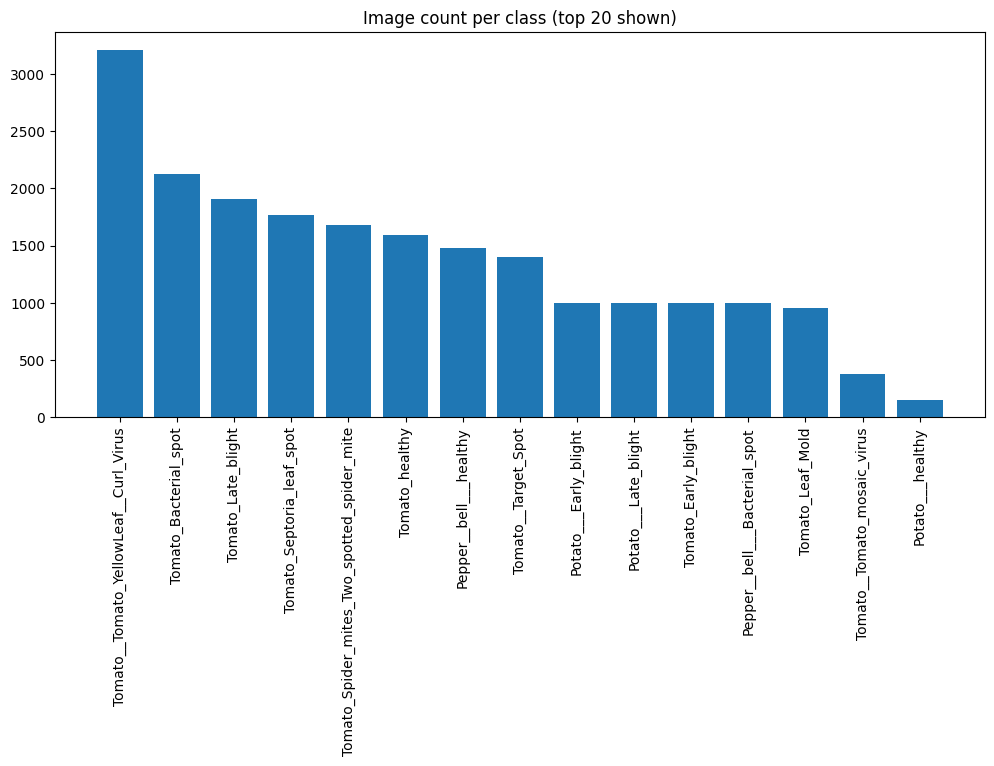

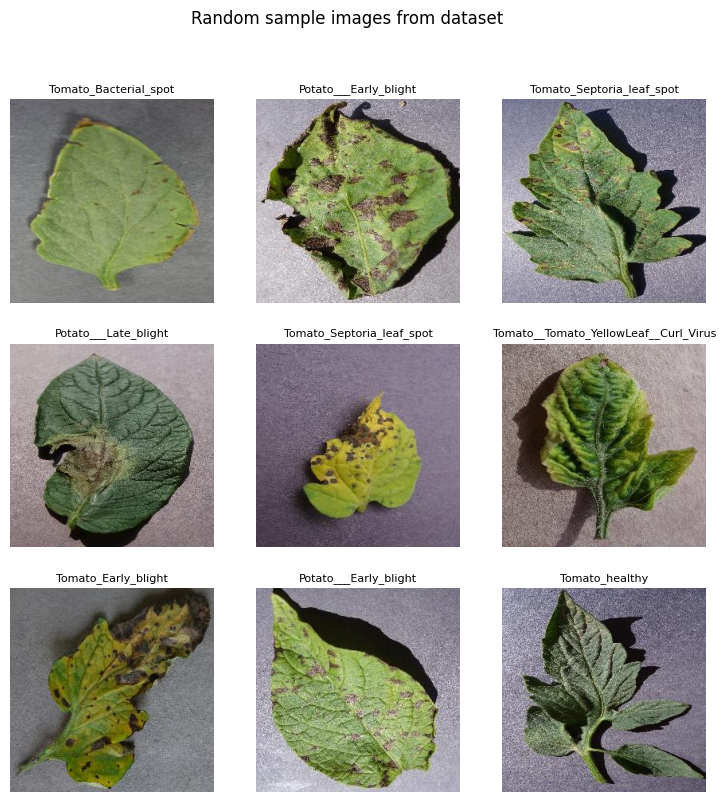

In [ ]:
class_dirs = [d for d in sorted(os.listdir(DATA_DIR)) if os.path.isdir(os.path.join(DATA_DIR, d))]
print("Found classes (sample):", class_dirs[:10])
def count_images(folder):
    return sum(1 for f in os.listdir(folder) if f.lower().endswith(('.jpg','.jpeg','.png')))

counts = {c: count_images(os.path.join(DATA_DIR, c)) for c in class_dirs}
print("Top 10 classes by image count:")
for c, n in sorted(counts.items(), key=lambda x: -x[1])[:10]:
    print(f"  {c}: {n}")

top_items = sorted(counts.items(), key=lambda x: -x[1])[:20]
labels, vals = zip(*top_items)
plt.figure(figsize=(12,5))
plt.bar(range(len(labels)), vals)
plt.xticks(range(len(labels)), labels, rotation=90)
plt.title("Image count per class (top 20 shown)")
plt.show()

import matplotlib.image as mpimg
plt.figure(figsize=(9,9))
for i in range(9):
    cls = random.choice(class_dirs)
    cls_folder = os.path.join(DATA_DIR, cls)
    files = [f for f in os.listdir(cls_folder) if f.lower().endswith(('.jpg','.jpeg','.png'))]
    fname = random.choice(files)
    img_path = os.path.join(cls_folder, fname)
    img = mpimg.imread(img_path)
    plt.subplot(3,3,i+1)
    plt.imshow(img)
    plt.title(cls, fontsize=8)
    plt.axis('off')
plt.suptitle("Random sample images from dataset")
plt.show()

In [ ]:
IMG_SIZE = (128,128)
BATCH_SIZE = 32
SEED = 42

train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)
class_names = train_ds.class_names
print("Classes detected by loader:", class_names)

Found 20638 files belonging to 15 classes.
Using 16511 files for training.
Found 20638 files belonging to 15 classes.
Using 4127 files for validation.
Classes detected by loader: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
], name="augmentation")

In [ ]:
y_train_list = []
for _, labels in train_ds.unbatch():
    y_train_list.append(int(labels.numpy()))
y_train_arr = np.array(y_train_list)

from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_arr), y=y_train_arr)
class_weights = {i: cw[i] for i in range(len(cw))}
print("Class weights sample:", list(class_weights.items())[:6])

Class weights sample: [(0, np.float64(1.3810957758260143)), (1, np.float64(0.9359977324263039)), (2, np.float64(1.3572544184134814)), (3, np.float64(1.3555829228243022)), (4, np.float64(9.096969696969698)), (5, np.float64(0.652866745749308))]


In [ ]:
# First CNN model
cnn = models.Sequential([
    layers.Rescaling(1./255, input_shape=IMG_SIZE+(3,)),
    data_augmentation,
    layers.Conv2D(32,3,activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64,3,activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128,3,activation='relu'), layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_cnn.h5", save_best_only=True, monitor='val_loss')
]

history_cnn = cnn.fit(train_ds, validation_data=val_ds, epochs=8, class_weight=class_weights, callbacks=callbacks)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,575 (12.61 MB)

 Trainable params: 3,306,575 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2315 - loss: 2.4011

516/516 ━━━━━━━━━━━━━━━━━━━━ 608s 1s/step - accuracy: 0.2317 - loss: 2.4006 - val_accuracy: 0.4909 - val_loss: 1.5556
Epoch 2/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5208 - loss: 1.4895

516/516 ━━━━━━━━━━━━━━━━━━━━ 618s 1s/step - accuracy: 0.5208 - loss: 1.4893 - val_accuracy: 0.7238 - val_loss: 0.8233
Epoch 3/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6483 - loss: 1.0600

516/516 ━━━━━━━━━━━━━━━━━━━━ 616s 1s/step - accuracy: 0.6483 - loss: 1.0599 - val_accuracy: 0.7323 - val_loss: 0.8012
Epoch 4/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7051 - loss: 0.8677

516/516 ━━━━━━━━━━━━━━━━━━━━ 609s 1s/step - accuracy: 0.7051 - loss: 0.8677 - val_accuracy: 0.7994 - val_loss: 0.5827
Epoch 5/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 628s 1s/step - accuracy: 0.7505 - loss: 0.7219 - val_accuracy: 0.7923 - val_loss: 0.6122
Epoch 6/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7704 - loss: 0.6659

516/516 ━━━━━━━━━━━━━━━━━━━━ 614s 1s/step - accuracy: 0.7704 - loss: 0.6658 - val_accuracy: 0.8362 - val_loss: 0.4981
Epoch 7/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.7944 - loss: 0.5967 - val_accuracy: 0.8071 - val_loss: 0.5889
Epoch 8/8
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8149 - loss: 0.5189

516/516 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.8149 - loss: 0.5189 - val_accuracy: 0.8883 - val_loss: 0.3063


In [ ]:
#Second VGG16
base = VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE+(3,))
base.trainable = False

inputs = layers.Input(shape=IMG_SIZE+(3,))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

vgg = models.Model(inputs, outputs)
vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
vgg.summary()

callbacks_vgg = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("best_vgg.h5", save_best_only=True, monitor='val_loss')
]

history_vgg = vgg.fit(train_ds, validation_data=val_ds, epochs=6, class_weight=class_weights, callbacks=callbacks_vgg)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation (Sequential)       │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │         3,855 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849,871 (56.65 MB)

 Trainable params: 135,183 (528.06 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

Epoch 1/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.3135 - loss: 2.1168

516/516 ━━━━━━━━━━━━━━━━━━━━ 3596s 7s/step - accuracy: 0.3137 - loss: 2.1160 - val_accuracy: 0.6079 - val_loss: 1.2720
Epoch 2/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6110 - loss: 1.2066

516/516 ━━━━━━━━━━━━━━━━━━━━ 3602s 7s/step - accuracy: 0.6110 - loss: 1.2064 - val_accuracy: 0.7240 - val_loss: 0.8894
Epoch 3/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6685 - loss: 0.9863

516/516 ━━━━━━━━━━━━━━━━━━━━ 3565s 7s/step - accuracy: 0.6685 - loss: 0.9863 - val_accuracy: 0.7378 - val_loss: 0.8167
Epoch 4/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7031 - loss: 0.8934

516/516 ━━━━━━━━━━━━━━━━━━━━ 3618s 7s/step - accuracy: 0.7031 - loss: 0.8933 - val_accuracy: 0.7579 - val_loss: 0.7411
Epoch 5/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7258 - loss: 0.8275

516/516 ━━━━━━━━━━━━━━━━━━━━ 3579s 7s/step - accuracy: 0.7257 - loss: 0.8275 - val_accuracy: 0.7676 - val_loss: 0.7056
Epoch 6/6
516/516 ━━━━━━━━━━━━━━━━━━━━ 3661s 7s/step - accuracy: 0.7254 - loss: 0.8071 - val_accuracy: 0.7647 - val_loss: 0.7096


CNN val acc: 0.888   VGG val acc: 0.765
Using best_model: CNN
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 523ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 540ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/

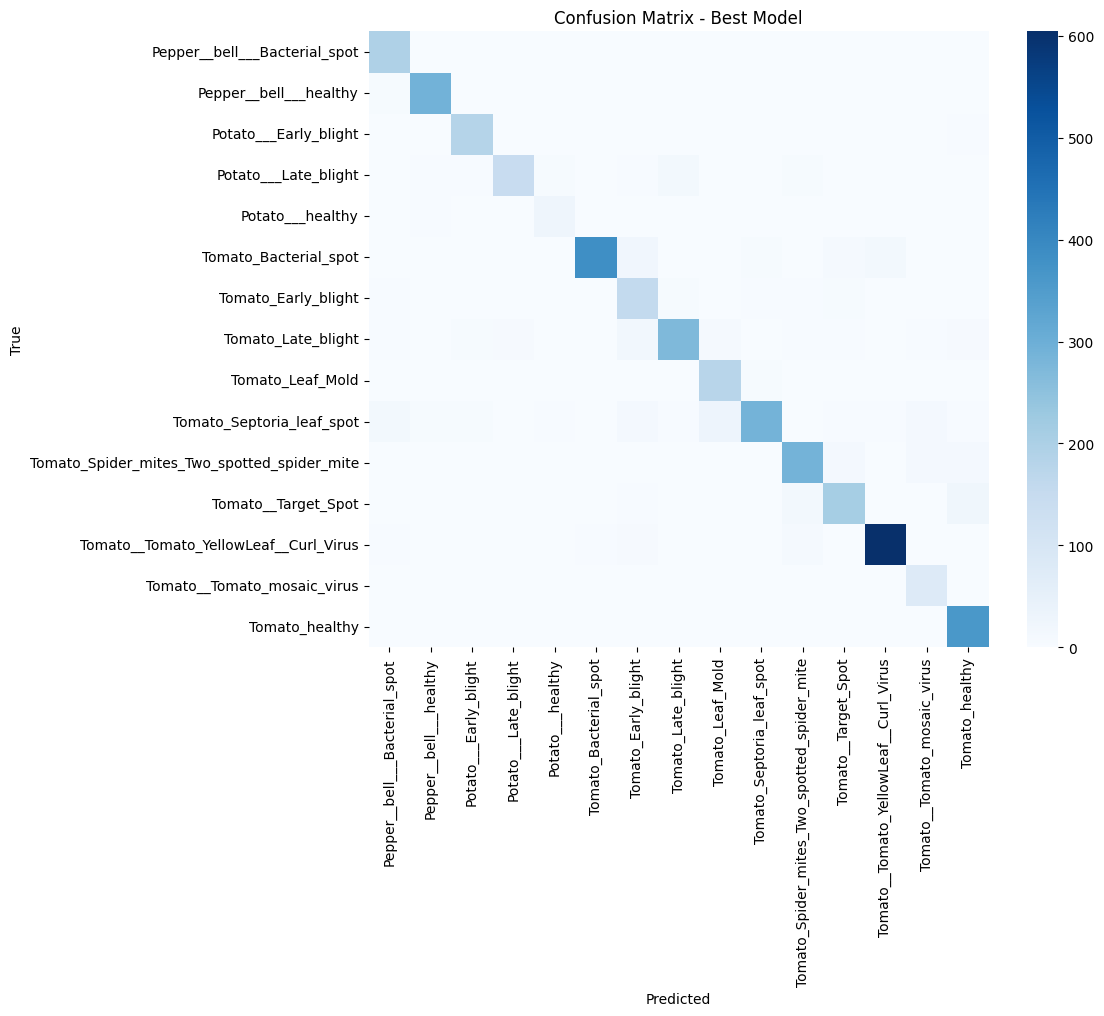

Final metrics -> Accuracy: 0.888, Precision: 0.856, Recall: 0.892, F1: 0.867


In [ ]:
cnn_val_acc = history_cnn.history['val_accuracy'][-1]
vgg_val_acc = history_vgg.history['val_accuracy'][-1]
print(f"CNN val acc: {cnn_val_acc:.3f}   VGG val acc: {vgg_val_acc:.3f}")

best_model = vgg if vgg_val_acc >= cnn_val_acc else cnn
print("Using best_model:", "VGG" if best_model is vgg else "CNN")

y_true = []
y_pred = []
for images, labels in val_ds:
    probs = best_model.predict(images)
    preds = np.argmax(probs, axis=1)
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, zero_division=0))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=False, cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - Best Model")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.show()

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='macro', zero_division=0)
rec = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
print(f"Final metrics -> Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")

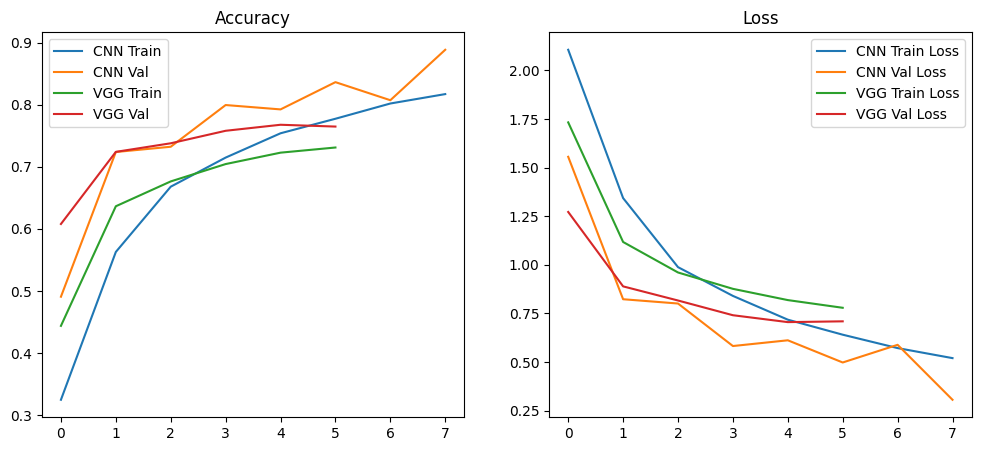

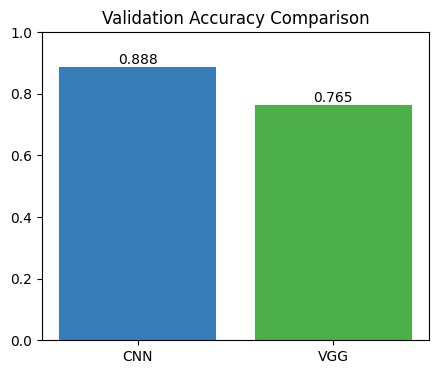

In [ ]:
# Plot accuracy
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='CNN Train')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Val')
plt.plot(history_vgg.history['accuracy'], label='VGG Train')
plt.plot(history_vgg.history['val_accuracy'], label='VGG Val')
plt.legend(); plt.title("Accuracy")

# Plot loss
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='CNN Train Loss')
plt.plot(history_cnn.history['val_loss'], label='CNN Val Loss')
plt.plot(history_vgg.history['loss'], label='VGG Train Loss')
plt.plot(history_vgg.history['val_loss'], label='VGG Val Loss')
plt.legend(); plt.title("Loss")
plt.show()

# Bar chart comparing final values
names = ["CNN", "VGG"]
vals = [cnn_val_acc, vgg_val_acc]
plt.figure(figsize=(5,4))
plt.bar(names, vals, color=['#377eb8','#4daf4a'])
plt.ylim(0,1)
for i,v in enumerate(vals): plt.text(i, v+0.01, f"{v:.3f}", ha='center')
plt.title("Validation Accuracy Comparison")
plt.show()

Saved disease_info.csv:
                Disease                                        Description  \
0  Tomato___Late_blight  Fungal disease causing dark lesions on leaves/...   
1    Tomato___Leaf_Mold  Fungal infection producing yellow and moldy pa...   
2     Apple___Black_rot  Fungal rot causing black lesions on fruit and ...   

                                           Treatment  
0  Remove infected leaves, apply recommended fung...  
1  Improve ventilation, copper sprays; remove inf...  
2  Prune and burn infected parts; fungicide appli...  
Predicting for sample: /content/plantvillage/PlantVillage/Pepper__bell___Bacterial_spot/dd1be385-6753-4a84-ab24-bf4b9ede3950___NREC_B.Spot 9198.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted class: Tomato_Late_blight
No mapping found in disease_info.csv for Tomato_Late_blight


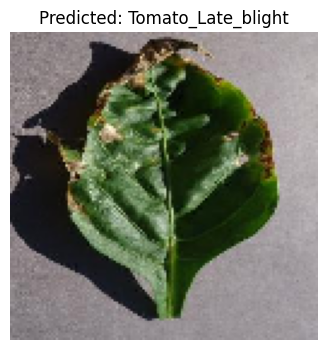

In [ ]:
disease_data = {
    "Disease": ["Tomato___Late_blight", "Tomato___Leaf_Mold", "Apple___Black_rot"],
    "Description": [
        "Fungal disease causing dark lesions on leaves/fruit.",
        "Fungal infection producing yellow and moldy patches.",
        "Fungal rot causing black lesions on fruit and twigs."
    ],
    "Treatment": [
        "Remove infected leaves, apply recommended fungicide.",
        "Improve ventilation, copper sprays; remove infected parts.",
        "Prune and burn infected parts; fungicide application."
    ]
}
df_info = pd.DataFrame(disease_data)
df_info.to_csv("disease_info.csv", index=False)
print("Saved disease_info.csv:")
print(pd.read_csv("disease_info.csv"))

sample_dir = os.path.join(DATA_DIR, class_dirs[0])
sample_file = next(f for f in os.listdir(sample_dir) if f.lower().endswith(('.jpg','.png','.jpeg')))
sample_path = os.path.join(sample_dir, sample_file)
print("Predicting for sample:", sample_path)

from tensorflow.keras.preprocessing import image
img = image.load_img(sample_path, target_size=IMG_SIZE)
img_arr = image.img_to_array(img) / 255.0
img_batch = np.expand_dims(img_arr, axis=0)

preds = best_model.predict(img_batch)
pred_class = class_names[np.argmax(preds)]
print("Predicted class:", pred_class)

info = pd.read_csv("disease_info.csv")
row = info[info['Disease'] == pred_class]
if not row.empty:
    print("Description:", row.iloc[0]['Description'])
    print("Treatment:", row.iloc[0]['Treatment'])
else:
    print("No mapping found in disease_info.csv for", pred_class)

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {pred_class}")
plt.show()

In [ ]:
# Save best model
if best_model is vgg:
    best_model.save("best_model_vgg.h5")
    print("Saved best_model_vgg.h5")
else:
    best_model.save("best_model_cnn.h5")
    print("Saved best_model_cnn.h5")

Saved best_model_cnn.h5


Saving Screenshot 2025-09-09 020622.png to Screenshot 2025-09-09 020622.png
Uploaded file: Screenshot 2025-09-09 020622.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Predicted Class: Tomato_Late_blight
No description/treatment info found for Tomato_Late_blight


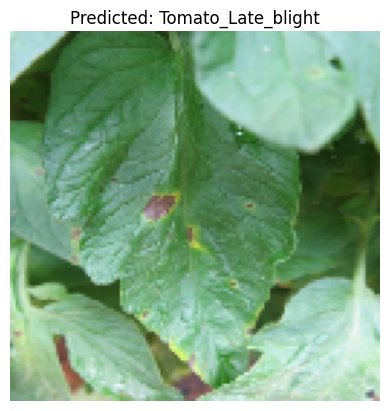

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image


uploaded = files.upload()

for filename in uploaded.keys():
    file_path = filename
    print("Uploaded file:", file_path)

    # preprocess
    img = image.load_img(file_path, target_size=IMG_SIZE)
    img_arr = image.img_to_array(img) / 255.0
    img_batch = np.expand_dims(img_arr, axis=0)

    # prediction
    preds = best_model.predict(img_batch)
    pred_class = class_names[np.argmax(preds)]

    print("Predicted Class:", pred_class)

    info = pd.read_csv("disease_info.csv")
    row = info[info['Disease'] == pred_class]
    if not row.empty:
        print("Description:", row.iloc[0]['Description'])
        print("Treatment:", row.iloc[0]['Treatment'])
    else:
        print("No description/treatment info found for", pred_class)

    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted: {pred_class}")
    plt.show()